In [1]:
import numpy as np
import stompy.model.delft.waq_scenario as dwaq
import matplotlib.pyplot as plt
from stompy import utils
# This gets us an edge-Q to cell-velocity:
from stompy.model.stream_tracer import U_perot

from stompy.grid import unstructured_grid

import stompy.plot.cmap as scmap
turbo=scmap.load_gradient('turbo.cpt')

In [2]:
import xarray as xr
print("XArray version: ",xr.version.version)

XArray version:  0.10.0


In [3]:
%matplotlib notebook

In [15]:
# Load the DWAQ hydro.
# This could also be done with either the DFM map output, or the
# DWAQ output (if it was configured to output velocity)
# Since you certainly have access to the DWAQ hydro (i.e. the DWAQ-formatted
# hydro output from from DFM), then I'm using that data.  It's probably the
# most involved of the ways to plot velocity and mixing.

# Older run:
# hydro=dwaq.HydroFiles('/hpcvol1/public/sfb_dfm_v2/wy2013c/DFM_DELWAQ_wy2013c_adj/wy2013c.hyd')

# Newer run:
hydro=dwaq.HydroFiles('/hpcvol1/emma/sfb_dfm/runs/wy2013_temp/DFM_DELWAQ_wy2013_temp_adj/wy2013_temp.hyd')

In [5]:
# We'll need to infer the structure of the DWAQ grid in order to make
# sense of the flows and volumes
hydro.infer_2d_elements()
# just to be sure that the reshaping below is kosher, here
# check the ordering. for dense hydro this should be fine.
assert np.all( 0==np.std( hydro.seg_to_2d_element.reshape((10,-1)), axis=0) )
hydro.infer_2d_links()

g=hydro.grid()
unstructured_grid.cleanup_dfm_multidomains(g)
e2c=g.edge_to_cells(recalc=True)

INFO:HydroFiles:Area file has 20446.0 steps vs. 20449 expected - proceed with caution
INFO:HydroFiles:Inferring 2D elements, 0 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 50000 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 100000 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 150000 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 200000 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 250000 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 300000 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 350000 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 400000 / 499960 3-D segments
INFO:HydroFiles:Inferring 2D elements, 450000 / 499960 3-D segments
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:5121 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:Unstruct

In [6]:
# WAQ puts flows on "flowlinks", which are a subset of the edges
# in the grid (i.e. closed boundary edges in the grid are not flow links)
# This method creates a matrix M such that  M.dot(flow on flowlinks)=flow on grid edges.
M=hydro.flowlink_to_edge(g)

Link -1 -- 10329 does not map to a grid boundary, likely a discharge, and will be ignored.


INFO:utils:26791


Link -1 -- 16231 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 20193 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 24591 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 24572 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -2 -- 24572 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 23219 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 24606 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 27968 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 25412 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 25381 does not map to a grid boundary, likely a discharge, and will be ignored.
Link -1 -- 25213 does not map to a grid boundary, likely a discharge, and will be ignored.

INFO:utils:68721


Plotting Velocity
==

In [13]:
# Pull a sample velocity field
tidx=504 # Output is at 0.5h interval. Select some random time index

t_sec=hydro.t_secs[tidx] # time in seconds from DWAQ reference time

# Read 3D flow, per 'exchange', at that time
flow=hydro.flows(t_sec)

# Read 3D cell volumes at that time.
# Note that this is not quite exact.  Flow is averaged over time interval,
# while volume is instantaneous, so there is a minor time staggering
# that I'm ignoring.
volumes=hydro.volumes(t_sec)

# This sums flow in the vertical, to get flow on 'links'
flow_link=np.bincount(hydro.exch_to_2d_link['link'],
                      weights=flow[:hydro.n_exch_x]*hydro.exch_to_2d_link['sgn'])
# likewise, sum volumes in 3D 'segments' to 2D 'elements'.  But volumes we know
# are nicely laid out as [Nlayers,Ncells], so no need for bincount. 
vol_element=volumes.reshape( (10,g.Ncells())).sum(axis=0)

flow_edge=M.dot(flow_link)

# High velocities at the wetting/drying front can arise due to both the 
# time-staggering between volumes and flows, and that the model may sometimes
# attempt to simulate sheet flow.  A minimum depth here decreases this effect
# in very shallow cells, without altering velocity in deep cells.  A more
# heavy-handed approach could just set these velocities to zero, though that
# might lead to other artifacts
dz_min=0.2 
vol_min=dz_min*g.cells_area()
# Use perot formulation to go from (edge flow, cell volume) to cell velocity 
vel_cell=U_perot(g,flow_edge,np.maximum(vol_min,vol_element))

Plot on the hydro grid
--

<IPython.core.display.Javascript object>


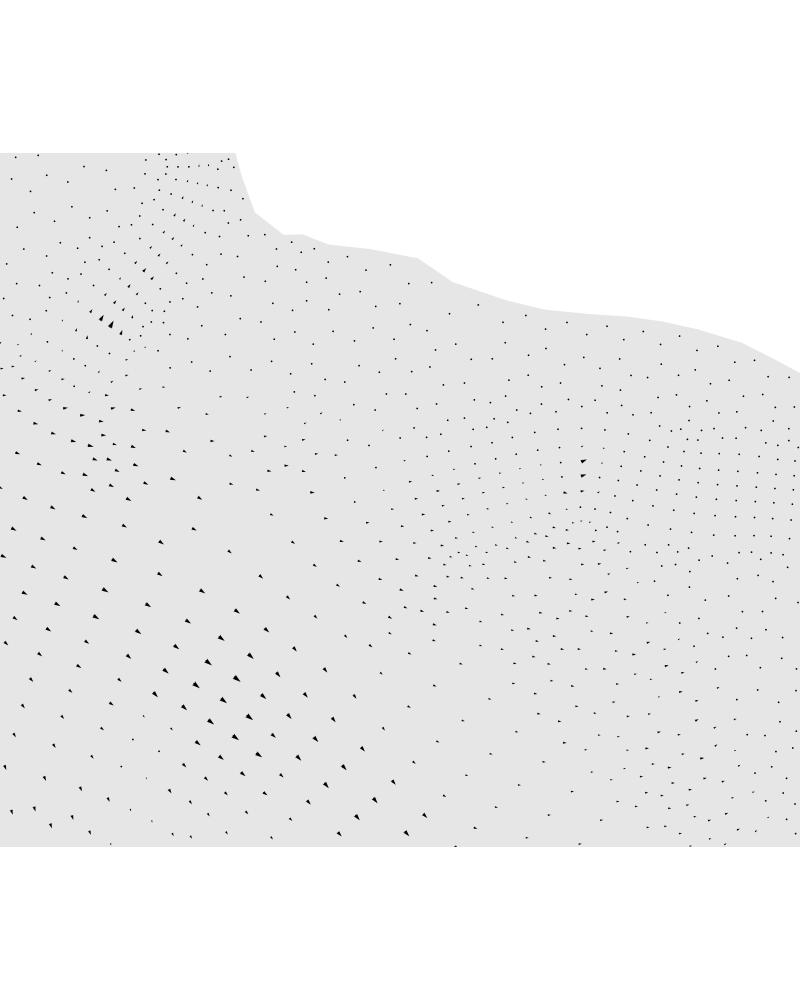

(550839.0, 590241.0, 4141763.0, 4186732.0)

In [12]:
# Could plot velocity on the original grid -- but it usually doesn't
# look very good.
zoom=(550839., 590241., 4141763., 4186732.) # Focus on South Bay
fig,ax=plt.subplots(figsize=(8,10))
g.plot_cells(ax=ax,color='0.9',clip=zoom)
cc=g.cells_centroid()
sel=g.cell_clip_mask(zoom) # Just plot a subset of the grid

ax.quiver(cc[sel,0],cc[sel,1],vel_cell[sel,0],vel_cell[sel,1])

ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
ax.axis(zoom)

Plot on Cartesian Grid
--

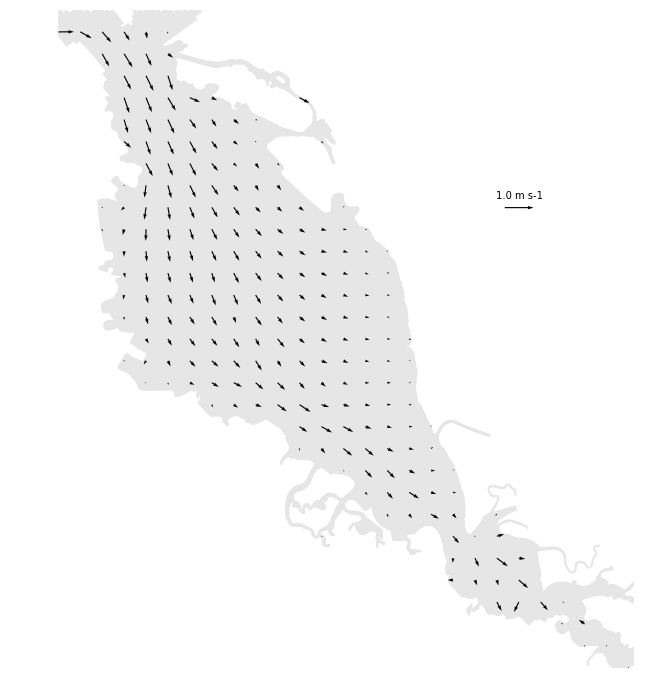

In [21]:
# get a gridded representation:
zoom=(550839., 590241., 4141763., 4186732.) # Focus on South Bay

# Plot a vector every 1500m in x and y:
x=np.arange(zoom[0],zoom[1],1500)
y=np.arange(zoom[2],zoom[3],1500)
X,Y=np.meshgrid(x,y)
XY=np.c_[X.ravel(), Y.ravel()]
cells=[g.select_cells_nearest(xy,inside=True) for xy in XY]
xyc=[(xy,c) for xy,c in zip(XY,cells) if c is not None]
xy,c=zip(*xyc)
xy=np.array(xy)
c=np.array(c)

# Now we have nicely spaced vectors. 
fig,ax=plt.subplots(figsize=(8,10))
ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
ax.axis(zoom)

g.plot_cells(ax=ax,color='0.9',clip=zoom)

# In matplotlib ~ version 3.0, using a key with 'xy' scale units
# is broken.
# scale is inverse: use a larger scale value to get smaller arrows.
quiv=ax.quiver(xy[:,0],xy[:,1],vel_cell[c,0],vel_cell[c,1],
               scale=20,width=0.002,angles='xy',scale_units='width')

ax.quiverkey(quiv,0.8,0.7,1.0,"1.0 m s-1",coordinates='axes')

Plot Streamlines
--

In [22]:
# Finally, you can trace streamlines, which can be a nice visual but is VERY slow
# (due mainly to the code for making sure that streamlines don't bunch up too closely).
# Also this doesn't do well in animations, as the placement of each arrow is computed
# dynamically so in animation the arrows would bounce all over.
# It also has the downside that the length of the arrows doesn't always reflect the
# velocity -- some arrows are cut short because they get too close to another arrow).
from stompy.plot import stream_quiver

zoom=(550839., 590241., 4141763., 4186732.) # Focus on South Bay

# This may take 5 minutes or longer!
sq=stream_quiver.StreamlineQuiver(g,vel_cell,streamline_count=500,
                                  min_clearance=600,max_t=3600,max_dist=4000,
                                  clip=zoom)

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249210, 15 potential interiors


**************Island
*************Island
***Constrained center [  564439.46852407  4180173.0044164 ] fell outside cell 18526.  Lie and mark cell 'outside'
***Constrained center [  564107.66212925  4180467.29087121] fell outside cell 18823.  Lie and mark cell 'outside'
*Constrained center [  564102.42841636  4180471.73051727] fell outside cell 18820.  Lie and mark cell 'outside'
**Constrained center [  564026.11535578  4180530.97772966] fell outside cell 18853.  Lie and mark cell 'outside'
***Constrained center [  563967.8358456  4180570.9627494] fell outside cell 18913.  Lie and mark cell 'outside'
*Constrained center [  563771.83138648  4180721.30443584] fell outside cell 18975.  Lie and mark cell 'outside'
***Constrained center [  563595.24126866  4180875.09903444] fell outside cell 18974.  Lie and mark cell 'outside'
*-*Island
**Constrained center [  562866.26270769  4181393.37044161] fell outside cell 18998.  Lie and mark cell 'outside'
*******-****-**Island
*Constrained center [  

/home/rusty/python/stompy/grid/unstructured_grid.py:2513: RuntimeWarning: divide by zero encountered in true_divide
  cxy /= 6*A[:,None]


*-***-**-****--*-*--*--*-*-*-*-****Island
*Constrained center [  562823.16655229  4181991.67728516] fell outside cell 31410.  Lie and mark cell 'outside'
*Constrained center [  562816.60169855  4181995.8929237 ] fell outside cell 31411.  Lie and mark cell 'outside'
***Constrained center [  559898.07674182  4182171.47515893] fell outside cell 14070.  Lie and mark cell 'outside'
*Constrained center [  559869.93841113  4182185.87428025] fell outside cell 14345.  Lie and mark cell 'outside'
****-**-*-*-*-*-*-**Constrained center [  563216.56954461  4182097.83977626] fell outside cell 8517.  Lie and mark cell 'outside'
**-*--*-*Constrained center [  567240.21472982  4179486.41572341] fell outside cell 6815.  Lie and mark cell 'outside'
*Island
**-*-***Island
*-*Island
***--*Island
*Island
*Island
**-*..*Island
*Constrained center [  567305.21301925  4179574.7788377 ] fell outside cell 6847.  Lie and mark cell 'outside'
*-*Island
**--*Island
*-*Constrained center [  569020.50909394  4154624.

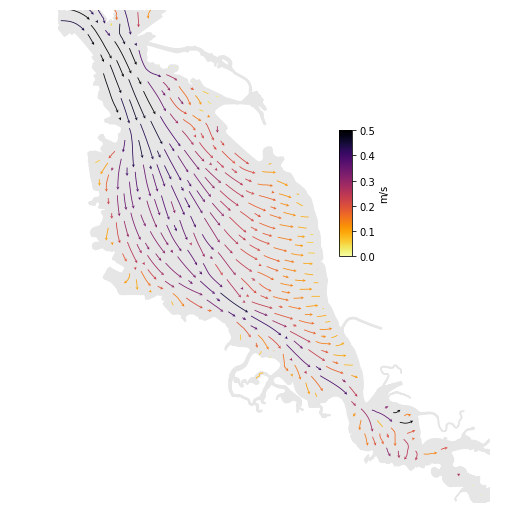

In [23]:
# Now we have nicely spaced vectors. 
fig,ax=plt.subplots(figsize=(6,7))
ax.axis('off')
fig.subplots_adjust(left=0,right=1,top=1,bottom=0)
ax.axis(zoom)
g.plot_cells(ax=ax,color='0.9',clip=zoom)

sq.size=70.
result=sq.plot_quiver(ax=ax,include_truncated=True)
colls=[result['lcoll'],result['pcoll']]

plt.setp(colls,clim=[0,0.5],cmap='inferno_r')
plt.colorbar(colls[0],cax=fig.add_axes([0.65,0.5,0.03,0.25]),label='m/s')

Vertical Mixing
==

In [24]:
# Vertical dispersion coefficient is a parameter that's passed from DFM to DWAQ
# Grab the vertdisper parameter:
vertdisp=hydro.parameters()['vertdisper']
vertdisp

INFO:HydroFiles:Segment depth will be inferred


In [25]:
vertdisp.load_from_segment_file() # Actually load the file:
# See what times are in there:
vertdisp._times # time in seconds from the model's reference time.

memmap([       0,     1800,     3600, ..., 36797400, 36799200, 36801000], dtype=int32)

In [26]:
# And the associated dispersion values
vertdisp.values.shape # 20449 timesteps, 499960 3D segments (10 layers, 49996 cells)

(20446, 499960)

In [27]:
# Pull one snapshot in time
vertdisp_snap=vertdisp.values[tidx,:] 

# Like volumes above, we happen to know that the segments in these files are 
# organized like: [all of surface layer, all of second layer, ... , all of bed layer].
# Also know that the layers are evenly spaced -- no stretching of sigma layers.
# So a shortcut to is to reshape:

Nlayers=10
vertdisp_3d=vertdisp_snap.reshape( Nlayers, g.Ncells()).T # Now this is [cells, layers]

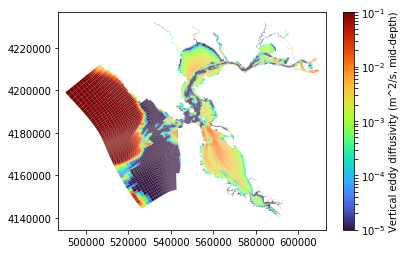

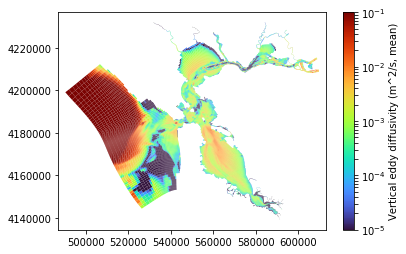

In [28]:
# Plot mid-water column diffusivity to check that it looks 
# reasonable:
from matplotlib.colors import LogNorm

plt.figure()
ccoll=g.plot_cells(values=vertdisp_3d[:,5].clip(1e-5),
                   norm=LogNorm(vmin=1e-5,vmax=0.1), cmap=turbo)
plt.axis('equal')
plt.colorbar(ccoll,label='Vertical eddy diffusivity (m^2/s, mid-depth)')

# And mean diffusivity (you could get more clever about the proper way of 
# averaging diffusivities, but mean is maybe a good starting point. Could
# think about geometric mean, harmonic mean, etc.)
plt.figure()
vertdisp_2d=vertdisp_3d.mean(axis=1)
ccoll=g.plot_cells(values=vertdisp_2d.clip(1e-5),
                   norm=LogNorm(vmin=1e-5,vmax=0.1), cmap=turbo)
plt.axis('equal')
plt.colorbar(ccoll,label='Vertical eddy diffusivity (m^2/s, mean)')

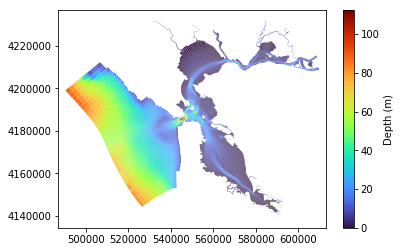

In [29]:
# To get mixing time, we need local depth.
# again, this value is readily accessible in the DFM map output,
# and also in the DWAQ output.  But when only reading the DFM->DWAQ
# hydro data like this, get depth by dividing vertically-integrated volume
# by cell area:
cell_depth= vol_element / g.cells_area()

# And plot to make sure it's reasonable:
plt.figure()
ccoll=g.plot_cells(values=cell_depth,cmap=turbo)
plt.colorbar(ccoll,label='Depth (m)')
plt.axis('equal') ;

/opt/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:1029: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)
/opt/anaconda3/lib/python3.5/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


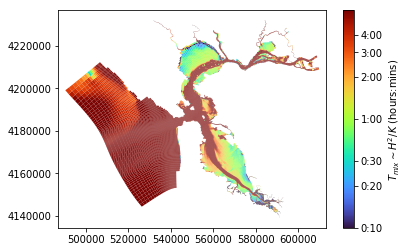

In [30]:
# Mixing time.  I'm going with arithmetic mean of diffusivity for simplicity
# Mixing time ~ depth^2 / K
T_s=np.array(cell_depth**2 / vertdisp_2d)
T_s[ np.isinf(T_s)]=np.nan 

plt.figure()
vmin=10 # 10 minutes
vmax=6*60 # 6 hours

ccoll=g.plot_cells(values=(T_s/60),
                   cmap=turbo,norm=LogNorm(vmin=vmin,vmax=vmax))

cbar=plt.colorbar(ccoll,label='$T_{mix} \sim H^2/K$ (hours:mins)')
# Make the labels a bit nicer
cbar.set_ticks([10,20,30,60,120,180,240])
cbar.set_ticklabels(["0:10","0:20","0:30","1:00","2:00","3:00","4:00"])
plt.axis('equal') ;

This is saying that the deeper parts of the Bay take over 5 hours to mix. But this is based
on a single moment in time, so really you'd have to think through what you really want to
show, and whether to also integrate or average vertical mixing over a tidal cycle.